In [1]:
import sys
import os

# Racine du projet (1 niveau au-dessus du notebook)
sys.path.append(os.path.abspath(".."))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from src.data_loader import DataLoader
from src.returns import compute_log_returns

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)


In [2]:
ETF_LIST = ["XLK", "XLF", "XLE", "XLV", "XLI", "XLY", "XLP", "XLU"]

loader = DataLoader("../data/raw")
prices = loader.load_prices(ETF_LIST)
returns = compute_log_returns(prices)


In [3]:
# fenêtre temporelle pour PCA roulante
WINDOW = 252  # ~1 an de trading
N_COMPONENTS = 3


In [4]:
# Fonction pour effectuer une PCA roulante

def rolling_pca(returns, window, n_components):
    dates = []
    explained_variances = []
    loadings_pc1 = []

    for i in range(window, len(returns)):
        window_data = returns.iloc[i-window:i]

        scaler = StandardScaler()
        X = scaler.fit_transform(window_data.values)

        pca = PCA(n_components=n_components)
        pca.fit(X)

        dates.append(returns.index[i])
        explained_variances.append(pca.explained_variance_ratio_)

        loadings_pc1.append(pca.components_[0])

    explained_df = pd.DataFrame(
        explained_variances,
        index=dates,
        columns=[f"PC{i+1}" for i in range(n_components)]
    )

    loadings_pc1_df = pd.DataFrame(
        loadings_pc1,
        index=dates,
        columns=returns.columns
    )

    return explained_df, loadings_pc1_df


In [5]:
# Appliquer la PCA roulante
explained_rolling, pc1_loadings_rolling = rolling_pca(
    returns,
    WINDOW,
    N_COMPONENTS
)


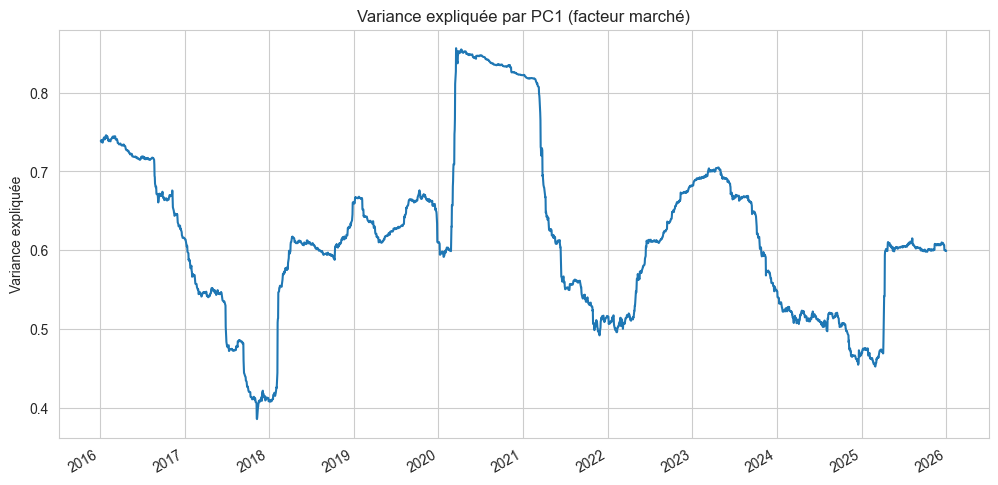

In [6]:
# Visualiser la variance expliquée par PC1 au fil du temps
explained_rolling["PC1"].plot()
plt.title("Variance expliquée par PC1 (facteur marché)")
plt.ylabel("Variance expliquée")
plt.show()


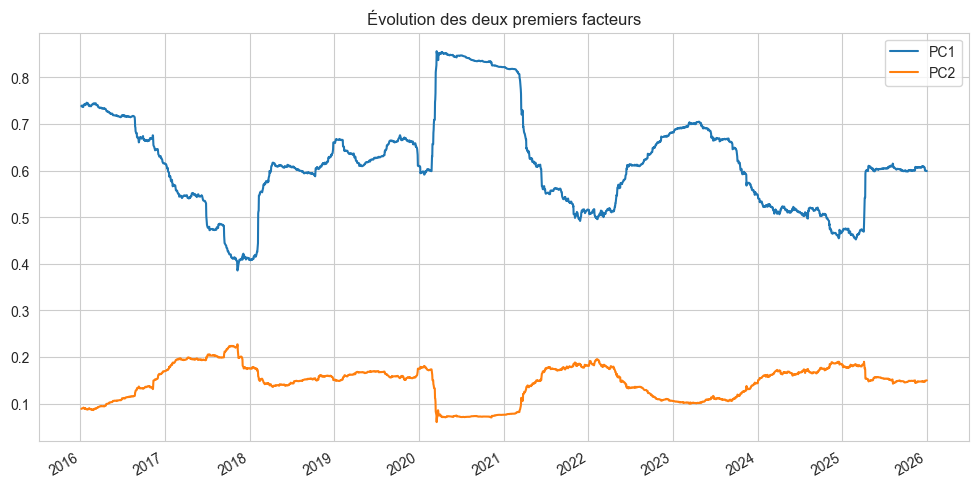

In [7]:
# Visualiser l'évolution des deux premiers facteurs
explained_rolling[["PC1", "PC2"]].plot()
plt.title("Évolution des deux premiers facteurs")
plt.show()


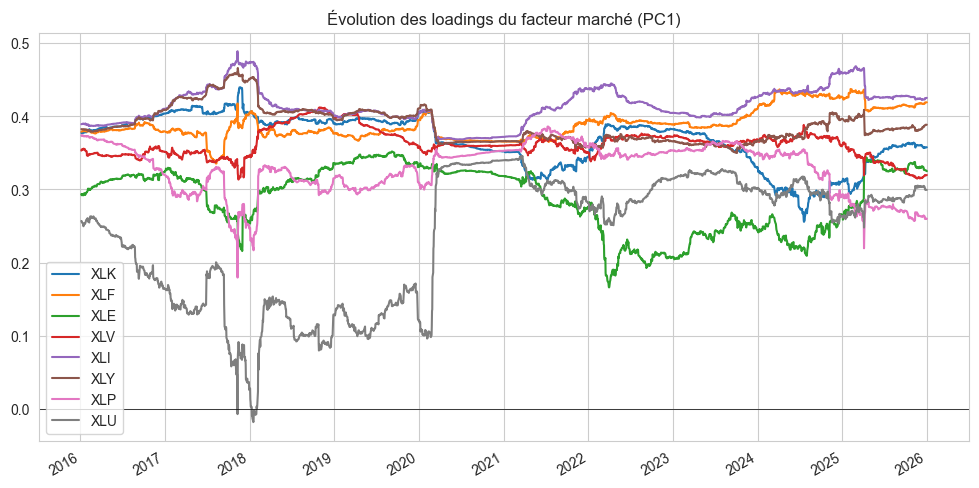

In [8]:
# Visualiser l'évolution des loadings du facteur marché (PC1)

pc1_loadings_rolling.plot()
plt.title("Évolution des loadings du facteur marché (PC1)")
plt.axhline(0, color="black", linewidth=0.5)
plt.show()


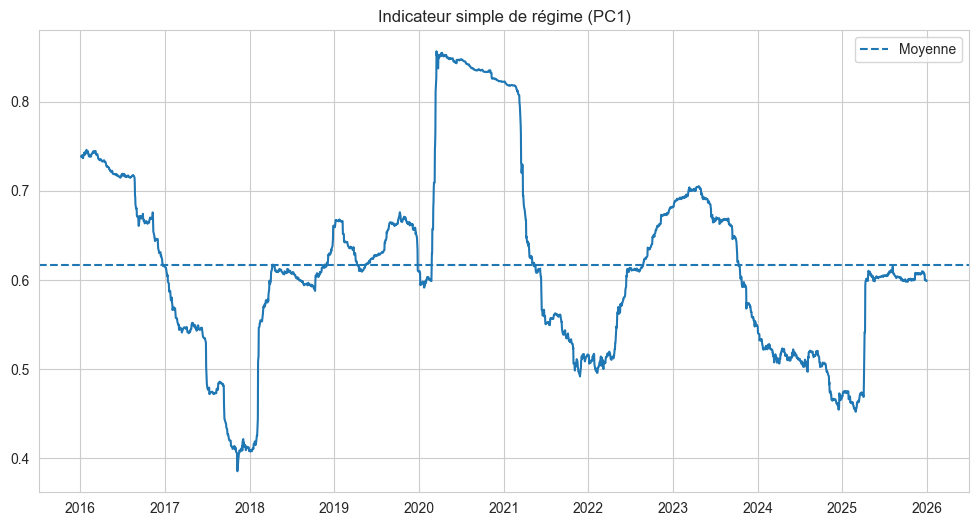

In [9]:
# Indicateur simple de régime basé sur PC1

regime_indicator = explained_rolling["PC1"]

plt.plot(regime_indicator)
plt.axhline(regime_indicator.mean(), linestyle="--", label="Moyenne")
plt.legend()
plt.title("Indicateur simple de régime (PC1)")
plt.show()
